# Step 2: 리워드 모델 파인튜닝
__인간 선호도를 활용한 SAWYER 보상 모델 트레이닝__

__Our SAWYER Process__

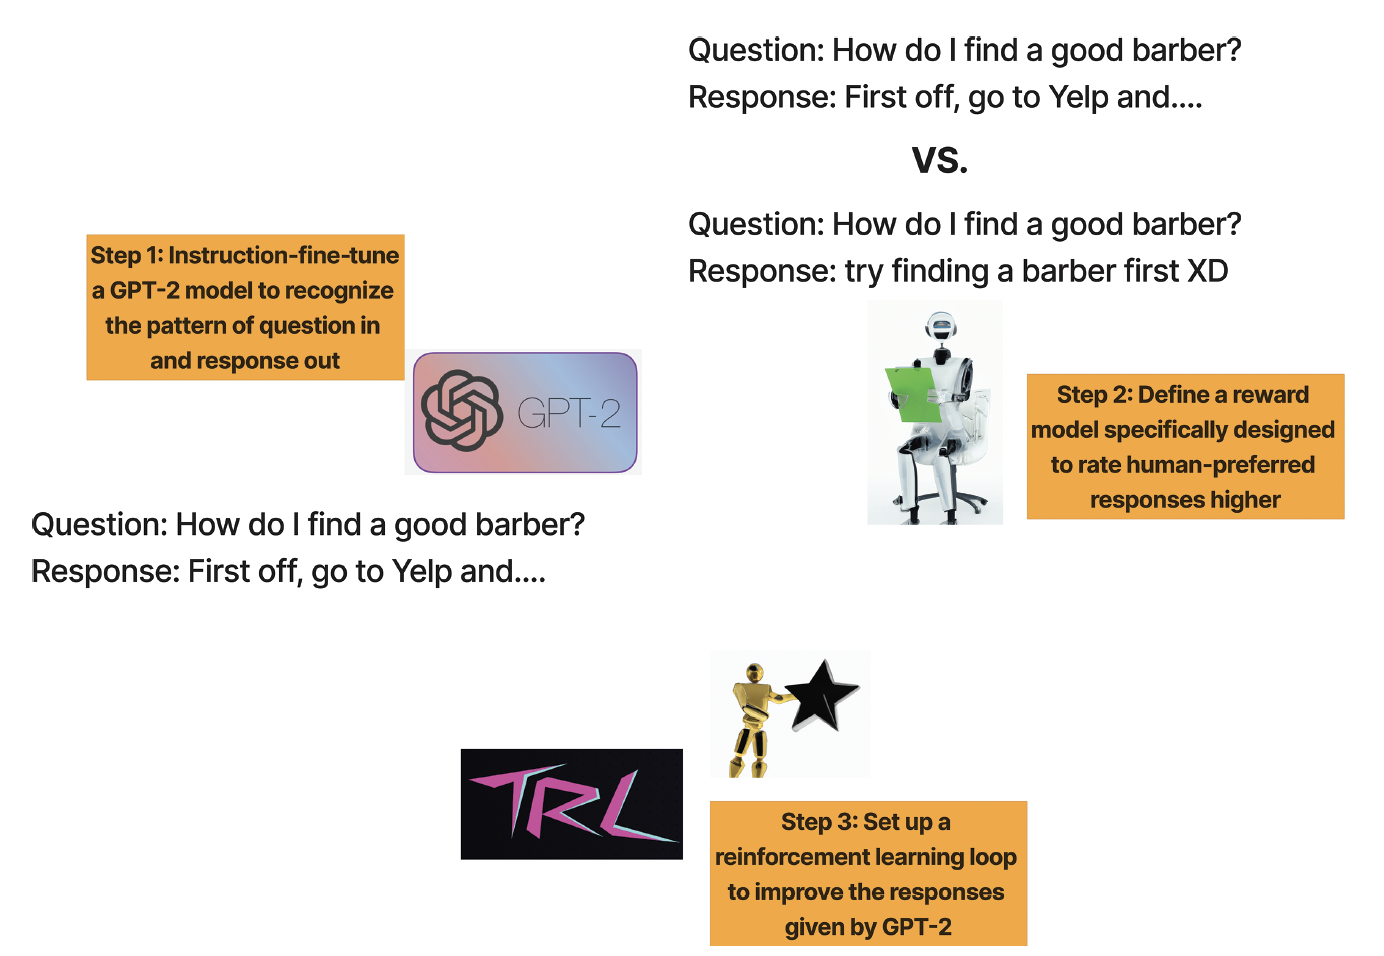

# 1. 초기화

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device

device(type='cuda')

In [26]:
import os

import torch
import evaluate
import numpy as np
import torch.nn as nn
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from datasets import load_dataset, Dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    HfArgumentParser,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.utils import PaddingStrategy
import json

In [27]:
set_seed(42)

# 2. 데이터 로딩

## 2.1 데이터 확인

comparison_data_v2.json은 다음과 같은 LLM의 응답 순위를 매겼습니다:

1. GPT-4
2. GPT-3.5
3. OPT-IML
4. DaVinci (InstructGPT)

GPT-4에 품질을 평가하도록 요청합니다.

각 데이터 요소에는 키가 있습니다:

- user_input: str, LLM을 쿼리하는 데 사용되는 프롬프트.
- responses_and_scores: list[str], list of
    - response: LLM의 응답
    - source: 응답을 생성한 LLM
    - score: 응답에 부여된 점수(GPT-4에서)

See more info [here](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/tree/main#how-good-is-the-data)

In [28]:
c = json.load(open('../data/comparison_data_v2.json'))

In [29]:
c[345]

{'user_input': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the importance of renewable energy',
 'responses_and_scores': [{'response': 'Renewable energy is becoming increasingly important in our world today as we strive to reduce our dependence on fossil fuels and shift to more sustainable sources of energy. Renewable energy sources such as wind, solar, and hydropower provide clean and reliable energy that can be used to power our homes, businesses, and vehicles. Renewable energy is also more cost-effective and efficient compared to other sources of energy. Additionally, renewable energy sources generate little to no pollution and greenhouse gas emissions, helping to reduce climate change. Renewable energy also helps to reduce our reliance on foreign countries for oil imports, thus making our nation more secure. Renewable energy is an important part of building a more sustainable future for our

In [30]:
print(c[345]['user_input'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the importance of renewable energy


In [31]:
for response in c[345]['responses_and_scores']:
    print(f'Response: {response["response"]}')
    print(f'Source: {response["source"]}')
    print(f'Score: {response["score"]}')
    print('----')

Response: Renewable energy is becoming increasingly important in our world today as we strive to reduce our dependence on fossil fuels and shift to more sustainable sources of energy. Renewable energy sources such as wind, solar, and hydropower provide clean and reliable energy that can be used to power our homes, businesses, and vehicles. Renewable energy is also more cost-effective and efficient compared to other sources of energy. Additionally, renewable energy sources generate little to no pollution and greenhouse gas emissions, helping to reduce climate change. Renewable energy also helps to reduce our reliance on foreign countries for oil imports, thus making our nation more secure. Renewable energy is an important part of building a more sustainable future for our planet.
Source: text-davinci-003
Score: 9.0
----
Response: Renewable energy is an essential aspect of modern life, as it plays a crucial role in protecting the environment, reducing our dependence on finite resources, 

## 2.2 datasets으로 로딩

In [32]:
dataset = load_dataset("json", data_files='../data/comparison_data_v2.json', split="train")

In [33]:
dataset[345]

{'responses_and_scores': [{'response': 'Renewable energy is becoming increasingly important in our world today as we strive to reduce our dependence on fossil fuels and shift to more sustainable sources of energy. Renewable energy sources such as wind, solar, and hydropower provide clean and reliable energy that can be used to power our homes, businesses, and vehicles. Renewable energy is also more cost-effective and efficient compared to other sources of energy. Additionally, renewable energy sources generate little to no pollution and greenhouse gas emissions, helping to reduce climate change. Renewable energy also helps to reduce our reliance on foreign countries for oil imports, thus making our nation more secure. Renewable energy is an important part of building a more sustainable future for our planet.',
   'score': 9.0,
   'source': 'text-davinci-003'},
  {'response': 'Renewable energy is an essential aspect of modern life, as it plays a crucial role in protecting the environmen

## 2.3 응답 비교 데이터 생성

다음 코드는 주어진 딕셔너리에서 'responses_and_scores' 키에 해당하는 값을 가져와 점수 튜플을 생성하는 함수입니다. 이 함수의 동작을 단계별로 설명하면 다음과 같습니다:

1. 함수는 `dictionary`라는 매개변수를 받습니다. 이 딕셔너리에는 'responses_and_scores'라는 키가 있다고 가정합니다.

2. `responses` 변수에 `dictionary['responses_and_scores']` 값을 할당합니다. 이는 응답과 점수가 포함된 리스트입니다.

3. `tuples` 변수를 빈 리스트로 초기화합니다. 이 리스트에는 생성된 점수 튜플이 저장됩니다.

4. 첫 번째 `for` 루프는 `responses` 리스트의 각 요소에 대해 반복합니다. 인덱스 `i`를 사용하여 현재 요소에 접근합니다.

5. 두 번째 `for` 루프는 `i + 1`부터 `responses` 리스트의 끝까지 반복합니다. 인덱스 `j`를 사용하여 현재 요소에 접근합니다. 이는 `i`번째 요소와 그 이후의 요소들 간의 조합을 생성하기 위한 것입니다.

6. `response_i`와 `response_j` 변수에 각각 `i`번째와 `j`번째 응답을 할당합니다.

7. `score_i`와 `score_j` 변수에 각각 `i`번째와 `j`번째 응답의 점수를 할당합니다.

8. 조건문 `if score_i > score_j:`를 사용하여 `score_i`가 `score_j`보다 큰 경우에만 다음 단계를 수행합니다.

9. `score_difference` 변수에 `score_i`와 `score_j`의 차이를 계산하여 할당합니다.

10. `tuples` 리스트에 `((response_i['response'], score_i), (response_j['response'], score_j), score_difference)`와 같은 형태의 튜플을 추가합니다. 이 튜플은 두 개의 응답과 점수, 그리고 점수 차이로 구성됩니다.

11. 모든 반복이 끝나면 `tuples` 리스트를 반환합니다.

이 함수는 주어진 응답과 점수 리스트에서 가능한 모든 조합을 생성하고, 점수가 더 높은 응답과 낮은 응답, 그리고 점수 차이를 튜플로 저장하여 반환합니다. 이를 통해 응답 간의 점수 차이를 비교하고 분석할 수 있습니다.

In [34]:
def get_score_tuples(dictionary):
    responses = dictionary['responses_and_scores']
    tuples = []

    for i in range(len(responses)):
        for j in range(i + 1, len(responses)):
            response_i = responses[i]
            response_j = responses[j]
            score_i = response_i['score']
            score_j = response_j['score']
            
            if score_i > score_j:
                score_difference = score_i - score_j
                tuples.append(((response_i['response'], score_i), (response_j['response'], score_j), score_difference))

    return tuples

다음 코드는 `dataset`의 각 행(row)에 대해 `get_score_tuples` 함수를 적용하여 새로운 예제를 생성하는 과정을 보여줍니다. 코드를 단계별로 설명하면 다음과 같습니다:

1. `new_examples` 리스트를 빈 리스트로 초기화합니다. 이 리스트에는 새로 생성된 예제들이 저장됩니다.

2. 첫 번째 `for` 루프에서 `dataset`의 각 행(row)에 대해 반복합니다.

3. 두 번째 `for` 루프에서는 `get_score_tuples` 함수를 현재 행(row)에 적용하여 반환된 점수 튜플들을 반복합니다.

4. 각 점수 튜플(`pair`)에 대해 다음 작업을 수행합니다:
   - `'instruction'` 키를 가진 딕셔너리를 생성합니다. 값은 `row['user_input']`에서 '### Instruction:\n' 이후의 부분을 추출하고, '### Input:\n'을 제거한 문자열입니다. 이는 사용자의 입력에서 명령(instruction)만을 추출하는 과정입니다.
   - `'text_j'` 키를 가진 딕셔너리를 생성합니다. 값은 `pair[0][0]`으로, 점수 튜플의 첫 번째 응답에 해당합니다.
   - `'text_k'` 키를 가진 딕셔너리를 생성합니다. 값은 `pair[1][0]`으로, 점수 튜플의 두 번째 응답에 해당합니다.
   - `'score_diff'` 키를 가진 딕셔너리를 생성합니다. 값은 `pair[2]`로, 점수 튜플의 점수 차이에 해당합니다.

5. 생성된 딕셔너리를 `new_examples` 리스트에 추가합니다.

6. 모든 반복이 끝나면 `new_examples` 리스트에는 각 행(row)의 점수 튜플에서 생성된 새로운 예제들이 저장됩니다.

이 코드는 원래의 데이터셋(`dataset`)을 기반으로 새로운 예제를 생성하는 과정을 보여줍니다. 각 예제는 사용자의 입력에서 추출한 명령(instruction)과 두 개의 응답(`text_j`와 `text_k`), 그리고 점수 차이(`score_diff`)로 구성됩니다. 이렇게 생성된 예제들을 활용하여 추가적인 분석이나 모델 학습 등을 수행할 수 있습니다.

In [35]:
new_examples = []
for row in dataset:
    for pair in get_score_tuples(row):
        new_examples.append({
            'instruction': row['user_input'].split('### Instruction:\n')[-1].replace('### Input:\n', ''),
            'text_j': pair[0][0],
            'text_k': pair[1][0],
            'score_diff': pair[2]
        })

In [36]:
len(dataset)

52001

In [37]:
len(new_examples)

95147

In [38]:
new_examples[0]

{'instruction': 'Give three tips for staying healthy.',
 'text_j': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
 'text_k': 'Eat healthy, exercise, and sleep.',
 'score_diff': 1.0}

`pairs_dataset = Dataset.from_list(new_examples)`는 이전에 생성한 `new_examples` 리스트를 사용하여 새로운 `Dataset` 객체를 생성하는 코드입니다. `from_list()` 메서드는 리스트를 입력으로 받아 `Dataset` 객체로 변환합니다.

`pairs_dataset = pairs_dataset.train_test_split(train_size=.8, seed=42)`는 생성된 `pairs_dataset`을 train set과 test set으로 분할하는 코드입니다. `train_test_split()` 메서드는 다음과 같은 매개변수를 사용합니다:
- `train_size`: train set의 비율을 지정합니다. 여기서는 0.8로 설정되어 있으므로, 전체 데이터셋의 80%가 train set으로 할당됩니다.
- `seed`: 랜덤 시드를 지정합니다. 같은 시드 값을 사용하면 동일한 데이터셋 분할을 재현할 수 있습니다. 여기서는 42로 설정되어 있습니다.

`train_test_split()` 메서드는 분할된 데이터셋을 `DatasetDict` 형태로 반환합니다. 반환된 `DatasetDict`에는 'train'과 'test' 키가 있으며, 각각 train set과 test set에 해당하는 `Dataset` 객체를 값으로 가집니다.

마지막으로 `pairs_dataset`을 출력하면 분할된 데이터셋의 정보를 확인할 수 있습니다. 출력 결과는 다음과 같은 형식일 것입니다:

```
DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 80% of total examples
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 20% of total examples
    })
})
```

출력 결과에서는 train set과 test set의 특성(features)과 각 set의 샘플 수(num_rows)를 확인할 수 있습니다.

이렇게 생성된 `pairs_dataset`은 훈련 및 평가를 위해 사용될 수 있습니다. train set은 모델의 학습에 사용되고, test set은 학습된 모델의 성능을 평가하는 데 사용됩니다. 데이터셋을 분할하는 것은 모델의 일반화 능력을 평가하고 과적합을 방지하는 데 도움이 됩니다.

In [39]:
pairs_dataset = Dataset.from_list(new_examples)
pairs_dataset = pairs_dataset.train_test_split(train_size=.8, seed=42)
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 19030
    })
})

In [40]:
pairs_dataset['test'][0]

{'instruction': 'How did the Battle of Gettysburg change the course of the American Civil War?',
 'text_j': 'The Battle of Gettysburg, fought from July 1 to July 3 1863, is considered one of the most important and decisive battles in the American Civil War as it marked a major turning point in the conflict. Before the battle, the Confederate army, commanded by General Robert E. Lee, had been enjoying a string of victories and launched an invasion of the Northern states, hoping that a major victory on Northern soil would demoralize the Union and force them to seek peace. However, the Union army, led by General George G. Meade, was able to successfully repel the Confederate attack in a bloody and costly battle, with an estimated 23,000 Union and 28,000 Confederate casualties.\n\nThe Union victory at Gettysburg, along with the capture of the Confederate stronghold of Vicksburg on July 4 1863, changed the momentum of the war in favor of the Union. The Confederate army was forced to retreat

## 2.4 데이터 전처리

다음 코드는 주어진 예제(example)를 전처리하는 함수인 `preprocess_function`을 정의하고 있습니다. 이 함수는 각 예제를 받아 모델에 입력할 수 있는 형태로 변환하는 역할을 합니다. 코드의 동작을 단계별로 설명하면 다음과 같습니다:

1. `new_examples` 딕셔너리를 초기화합니다. 이 딕셔너리는 전처리된 데이터를 저장하는 데 사용됩니다.
   - "input_ids_j": 첫 번째 텍스트(text_j)의 입력 토큰 ID 리스트
   - "attention_mask_j": 첫 번째 텍스트(text_j)의 어텐션 마스크 리스트
   - "input_ids_k": 두 번째 텍스트(text_k)의 입력 토큰 ID 리스트
   - "attention_mask_k": 두 번째 텍스트(text_k)의 어텐션 마스크 리스트
   - "score_diff": 점수 차이 리스트

2. 예제의 점수 차이(score_diff)를 `new_examples['score_diff']` 리스트에 추가합니다.

3. 예제의 "instruction" 필드를 `question` 변수에 할당합니다. 이는 질문 또는 명령어를 나타냅니다.

4. `tokenizer`를 사용하여 `question`과 첫 번째 텍스트(text_j)를 토큰화합니다. 이때 `truncation=True`로 설정하여 텍스트의 길이를 제한합니다.
   - 토큰화된 결과는 `tokenized_j` 변수에 저장됩니다.

5. `tokenizer`를 사용하여 `question`과 두 번째 텍스트(text_k)를 토큰화합니다. 마찬가지로 `truncation=True`로 설정합니다.
   - 토큰화된 결과는 `tokenized_k` 변수에 저장됩니다.

6. 토큰화된 첫 번째 텍스트(text_j)의 입력 토큰 ID와 어텐션 마스크를 각각 `new_examples["input_ids_j"]`와 `new_examples["attention_mask_j"]` 리스트에 추가합니다.

7. 토큰화된 두 번째 텍스트(text_k)의 입력 토큰 ID와 어텐션 마스크를 각각 `new_examples["input_ids_k"]`와 `new_examples["attention_mask_k"]` 리스트에 추가합니다.

8. 전처리된 예제를 담고 있는 `new_examples` 딕셔너리를 반환합니다.

이 함수는 데이터셋의 각 예제에 대해 호출되며, 전처리된 예제들을 모아 새로운 데이터셋을 생성하는 데 사용됩니다. 전처리 과정에서는 토크나이저를 사용하여 텍스트를 토큰화하고, 입력 토큰 ID와 어텐션 마스크를 생성합니다. 또한 점수 차이(score_diff)도 함께 저장합니다.

전처리된 데이터셋은 모델의 입력으로 사용되며, 모델은 이를 기반으로 학습하고 예측을 수행합니다.

In [43]:
# 데이터 집합을 입력 + 출력의 쌍으로 변환합니다. 여기서 text_j는 선호하는 질문 + 답변이고 text_k는 다른 질문 + 답변입니다. 그런 다음 데이터 세트를 토큰화합니다.
def preprocess_function(example):
    new_examples = {
        "input_ids_j": [],
        "attention_mask_j": [],
        "input_ids_k": [],
        "attention_mask_k": [],
        "score_diff": []
    }

    new_examples['score_diff'].append(example['score_diff'])
    question = example["instruction"]
    tokenized_j = tokenizer(question, example['text_j'], truncation=True)
    tokenized_k = tokenizer(question, example['text_k'], truncation=True) 

    new_examples["input_ids_j"].append(tokenized_j["input_ids"])
    new_examples["attention_mask_j"].append(tokenized_j["attention_mask"])
    new_examples["input_ids_k"].append(tokenized_k["input_ids"])
    new_examples["attention_mask_k"].append(tokenized_k["attention_mask"])

    return new_examples

In [45]:
# 데이터 집합을 전처리하고 max_length보다 긴 QA를 필터링합니다.
pairs_dataset = pairs_dataset.map(preprocess_function, batched=False)

Map:   0%|          | 0/76117 [00:00<?, ? examples/s]

Map:   0%|          | 0/19030 [00:00<?, ? examples/s]

In [46]:
pairs_dataset.set_format('pt')

In [47]:
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 19030
    })
})

In [49]:
pairs_dataset['test'][0]

{'instruction': 'How did the Battle of Gettysburg change the course of the American Civil War?',
 'text_j': 'The Battle of Gettysburg, fought from July 1 to July 3 1863, is considered one of the most important and decisive battles in the American Civil War as it marked a major turning point in the conflict. Before the battle, the Confederate army, commanded by General Robert E. Lee, had been enjoying a string of victories and launched an invasion of the Northern states, hoping that a major victory on Northern soil would demoralize the Union and force them to seek peace. However, the Union army, led by General George G. Meade, was able to successfully repel the Confederate attack in a bloody and costly battle, with an estimated 23,000 Union and 28,000 Confederate casualties.\n\nThe Union victory at Gettysburg, along with the capture of the Confederate stronghold of Vicksburg on July 4 1863, changed the momentum of the war in favor of the Union. The Confederate army was forced to retreat

In [48]:
print(tokenizer.decode([0]))

print(tokenizer.decode([6179]))

print(tokenizer.decode([116]))

print(tokenizer.decode([4]))

print(tokenizer.decode([2]))

print(tokenizer.decode([133]))

<s>
How
?
.
</s>
The


In [50]:
pairs_dataset['train'][5]

{'instruction': 'Write an article about climate change.',
 'text_j': "Climate change is one of the most pressing and urgent issues of the modern world. It is an ever-evolving environmental threat that threatens the planet's future, especially with regards to the natural environment that we as humans depend upon. Over the decades, the scientific community has recorded a consistent and steady rise in global temperatures that can only be attributed to the increasing concentrations of Greenhouse gases in the atmosphere due to our continued burning of fossil fuels. This has sparked a chain reaction of catastrophic events that is wreaking havoc on the planet, such as extreme weather events, melting of polar ice caps and the ocean rising to unprecedented levels, threatening the future of entire cities and coastal areas.\n\nThe urgency of this global crisis is only compounded by the fact that climate change is happening much faster than predicted. This means that in order to maintain a livable

# 3. 모델 학습

아래 코드는 `TrainingArguments` 클래스를 사용하여 훈련 관련 인자들을 설정하는 부분입니다. 각 인자의 의미를 설명하면 다음과 같습니다:

- `output_dir`: 모델의 체크포인트와 로그 파일이 저장될 디렉토리 경로를 지정합니다. 여기서는 'sawyer_rm'으로 설정되어 있습니다.
- `per_device_train_batch_size`: 각 디바이스(GPU 또는 CPU)에서 사용할 train batch 크기를 지정합니다. 여기서는 8로 설정되어 있습니다.
- `per_device_eval_batch_size`: 각 디바이스에서 사용할 evaluation batch 크기를 지정합니다. 여기서는 32로 설정되어 있습니다.
- `num_train_epochs`: 전체 데이터셋에 대해 훈련을 반복할 epoch 수를 지정합니다. 여기서는 2로 설정되어 있습니다.
- `evaluation_strategy`: 평가 전략을 지정합니다. 여기서는 "epoch"으로 설정되어 있어, 각 epoch이 끝날 때마다 평가가 수행됩니다.
- `save_strategy`: 모델 저장 전략을 지정합니다. 여기서는 "epoch"으로 설정되어 있어, 각 epoch이 끝날 때마다 모델이 저장됩니다.
- `gradient_accumulation_steps`: 그래디언트 누적 단계 수를 지정합니다. 여기서는 4로 설정되어 있어, 4개의 배치마다 그래디언트가 누적되고 업데이트됩니다.
- `save_total_limit`: 저장할 체크포인트의 최대 개수를 지정합니다. 여기서는 5로 설정되어 있습니다.
- `remove_unused_columns`: 사용하지 않는 열을 제거할 것인지 여부를 지정합니다. 여기서는 False로 설정되어 있어, 사용하지 않는 열이 유지됩니다.
- `label_names`: 레이블 열의 이름을 지정합니다. 여기서는 빈 리스트로 설정되어 있어, 레이블 열이 없음을 나타냅니다.
- `fp16`: FP16 혼합 정밀도를 사용할 것인지 여부를 지정합니다. 여기서는 False로 설정되어 있어, FP16을 사용하지 않습니다.
- `load_best_model_at_end`: 훈련 종료 시점에 가장 좋은 성능을 보인 모델을 로드할 것인지 여부를 지정합니다. 여기서는 True로 설정되어 있어, 가장 좋은 모델이 로드됩니다.
- `logging_strategy`: 로깅 전략을 지정합니다. 여기서는 "steps"로 설정되어 있어, 지정된 단계마다 로깅이 수행됩니다.
- `logging_steps`: 로깅 단계 수를 지정합니다. 여기서는 10으로 설정되어 있어, 10 단계마다 로깅이 수행됩니다.

이러한 인자들은 `Trainer` 클래스에 전달되어 훈련 과정을 제어하고 설정하는 데 사용됩니다. 인자 값들은 데이터셋의 크기, 모델의 복잡도, 가용한 하드웨어 자원 등을 고려하여 적절히 조정될 수 있습니다.

In [41]:
training_args = TrainingArguments(
    output_dir='sawyer_rm',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=4,
    save_total_limit=5,
    remove_unused_columns=False,
    label_names=[],
    fp16=False,
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=10,
)

다음 코드는 Hugging Face의 Transformers 라이브러리를 사용하여 RoBERTa 모델을 불러오고 설정하는 부분입니다. 각 줄의 역할을 설명하면 다음과 같습니다:

1. `model_name = 'roberta-base'`: 사용할 모델의 이름을 지정합니다. 여기서는 'roberta-base'로 설정되어 있어, RoBERTa의 기본(base) 버전을 사용합니다.

2. `tokenizer = AutoTokenizer.from_pretrained(model_name)`: 지정된 모델 이름에 해당하는 토크나이저를 불러옵니다. `AutoTokenizer`는 모델 이름에 따라 적절한 토크나이저를 자동으로 선택하고 초기화합니다. 토크나이저는 입력 텍스트를 모델이 이해할 수 있는 형태로 변환하는 역할을 합니다.

3. `config = AutoConfig.from_pretrained(model_name)`: 지정된 모델 이름에 해당하는 설정(configuration)을 불러옵니다. `AutoConfig`는 모델 이름에 따라 적절한 설정을 자동으로 선택하고 초기화합니다. 설정에는 모델의 구조, 하이퍼파라미터 등이 포함됩니다.

4. `model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)`: 지정된 모델 이름에 해당하는 사전 훈련된 모델을 불러오고, 시퀀스 분류(Sequence Classification) 작업을 위해 설정합니다. `AutoModelForSequenceClassification`은 시퀀스 분류 작업에 적합한 모델 아키텍처를 자동으로 선택하고 초기화합니다. `num_labels` 매개변수는 분류할 레이블의 개수를 지정하는데, 여기서는 1로 설정되어 있어 이진 분류(binary classification) 작업을 수행할 수 있습니다.

다음 코드를 실행하면 'roberta-base' 모델을 기반으로 토크나이저, 설정, 모델이 불러와집니다. 이렇게 불러온 모델은 시퀀스 분류 작업을 위해 미세 조정(fine-tuning)되거나 직접 사용될 수 있습니다.

RoBERTa(Robustly Optimized BERT Pretraining Approach)는 BERT(Bidirectional Encoder Representations from Transformers)의 개선된 버전으로, 대규모 코퍼스에 대한 사전 훈련을 통해 자연어 처리 작업에서 우수한 성능을 보이는 모델입니다. RoBERTa는 BERT의 훈련 방식을 개선하고 더 큰 데이터셋을 사용하여 훈련되었으며, 다양한 자연어 처리 작업에서 높은 성능을 달성하였습니다.

In [42]:
# 크로스 인코더를 사용하여 질문과 답변을 함께 인코딩하여 점수를 생성합니다. 이는 시맨틱 검색 시스템에서 재순위를 매기기 위해 크로스 인코더를 사용한 것과 마찬가지로 크로스 인코더의 예상되는 사용 사례입니다.
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=1,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 코드는 `RewardDataCollatorWithPadding`이라는 데이터 콜레이터 클래스를 정의하고 있습니다. 데이터 콜레이터는 데이터셋의 배치를 생성하고 모델에 입력할 수 있는 형태로 변환하는 역할을 합니다.

`RewardDataCollatorWithPadding` 클래스는 다음과 같은 속성을 가집니다:
- `tokenizer`: 사전 학습된 토크나이저(PreTrainedTokenizerBase)
- `padding`: 패딩 전략(True, False, "longest", "max_length" 등)
- `max_length`: 최대 시퀀스 길이
- `pad_to_multiple_of`: 패딩 길이의 배수
- `return_tensors`: 반환할 텐서 형식("pt" 또는 "tf")

`__call__` 메소드는 데이터 콜레이터가 호출될 때 실행되며, 배치 데이터를 생성하고 반환합니다. 메소드의 동작을 단계별로 설명하면 다음과 같습니다:

1. `features_j`와 `features_k` 리스트를 초기화합니다. 이 리스트들은 각각 첫 번째 텍스트(text_j)와 두 번째 텍스트(text_k)의 특성을 저장합니다.

2. 입력으로 받은 `features` 리스트를 반복하면서 각 특성(feature)에 대해 다음 작업을 수행합니다:
   - 첫 번째 텍스트(text_j)의 입력 토큰 ID와 어텐션 마스크를 `features_j` 리스트에 추가합니다.
   - 두 번째 텍스트(text_k)의 입력 토큰 ID와 어텐션 마스크를 `features_k` 리스트에 추가합니다.

3. `tokenizer.pad()` 메소드를 사용하여 `features_j`를 패딩합니다. 이때 패딩 전략, 최대 길이, 패딩 길이의 배수, 반환할 텐서 형식 등을 지정합니다.
   - 패딩된 결과는 `batch_j` 변수에 저장됩니다.

4. 마찬가지로 `tokenizer.pad()` 메소드를 사용하여 `features_k`를 패딩합니다.
   - 패딩된 결과는 `batch_k` 변수에 저장됩니다.

5. `batch` 딕셔너리를 생성합니다. 이 딕셔너리에는 다음 키-값 쌍이 포함됩니다:
   - "input_ids_j": 첫 번째 텍스트(text_j)의 패딩된 입력 토큰 ID
   - "attention_mask_j": 첫 번째 텍스트(text_j)의 패딩된 어텐션 마스크
   - "input_ids_k": 두 번째 텍스트(text_k)의 패딩된 입력 토큰 ID
   - "attention_mask_k": 두 번째 텍스트(text_k)의 패딩된 어텐션 마스크
   - "score_diff": 점수 차이(score_diff) 리스트
   - "return_loss": 손실 반환 여부(True)

6. 생성된 `batch` 딕셔너리를 반환합니다.

이 데이터 콜레이터는 배치 데이터를 생성할 때 첫 번째 텍스트(text_j)와 두 번째 텍스트(text_k)를 별도로 처리하고 패딩합니다. 이를 통해 모델이 두 개의 텍스트를 독립적으로 처리할 수 있도록 합니다. 또한 점수 차이(score_diff)와 손실 반환 여부(return_loss)도 배치에 포함됩니다.

데이터 콜레이터는 데이터셋과 함께 사용되어 배치 데이터를 생성하고, 모델 학습 및 평가에 사용됩니다.

In [51]:
# j 대 k 형식의 데이터를 일괄 처리하는 특수 데이터 콜레이터를 정의해야 합니다.
@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append(
                {
                    "input_ids": feature["input_ids_j"].squeeze(),
                    "attention_mask": feature["attention_mask_j"].squeeze(),
                }
            )
            features_k.append(
                {
                    "input_ids": feature["input_ids_k"].squeeze(),
                    "attention_mask": feature["attention_mask_k"].squeeze(),
                }
            )
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "score_diff": [feature['score_diff'] for feature in features],
            "return_loss": True,
        }
        return batch

`accuracy = evaluate.load("accuracy")`는 Hugging Face의 `evaluate` 라이브러리를 사용하여 정확도(accuracy) 평가 지표를 로드하는 코드입니다.

`evaluate` 라이브러리는 다양한 평가 지표를 제공하며, 모델의 성능을 평가하는 데 사용됩니다. 이 라이브러리는 Hugging Face 생태계에서 널리 사용되며, 다양한 자연어 처리 작업에 대한 평가 지표를 포함하고 있습니다.

`evaluate.load("accuracy")`는 정확도 평가 지표를 로드합니다. 정확도는 분류 문제에서 모델이 정답을 맞힌 비율을 나타내는 지표입니다. 예를 들어, 이진 분류 문제에서 모델이 100개의 예측을 수행하고 그 중 80개를 정확하게 맞혔다면, 정확도는 0.8 또는 80%가 됩니다.

로드된 정확도 평가 지표는 `accuracy` 변수에 할당됩니다. 이후에는 `accuracy` 변수를 사용하여 모델의 예측 결과와 실제 레이블을 비교하고 정확도를 계산할 수 있습니다.

예를 들어, 다음과 같이 `accuracy` 변수를 사용하여 정확도를 계산할 수 있습니다:

```python
predictions = model.predict(test_dataset)
labels = test_dataset["labels"]
accuracy_score = accuracy.compute(predictions=predictions, references=labels)
print("Accuracy:", accuracy_score)
```

위의 코드에서는 `model.predict()`를 사용하여 테스트 데이터셋에 대한 예측을 수행하고, 실제 레이블과 함께 `accuracy.compute()`에 전달하여 정확도를 계산합니다. 계산된 정확도는 `accuracy_score` 변수에 저장되고 출력됩니다.

`evaluate` 라이브러리는 정확도 외에도 다양한 평가 지표를 제공하므로, 필요에 따라 다른 지표를 로드하고 사용할 수 있습니다. 예를 들어, `evaluate.load("f1")`을 사용하여 F1 스코어를 로드할 수 있습니다.

평가 지표를 사용하면 모델의 성능을 정량적으로 평가하고 비교할 수 있으며, 모델의 개선 사항을 파악하는 데 도움이 됩니다.

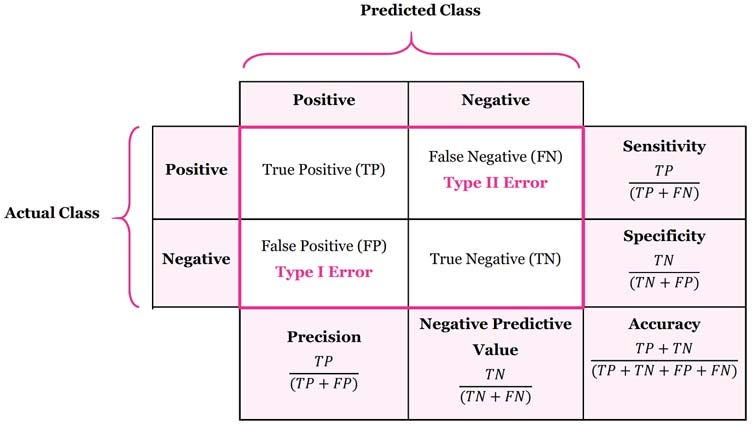 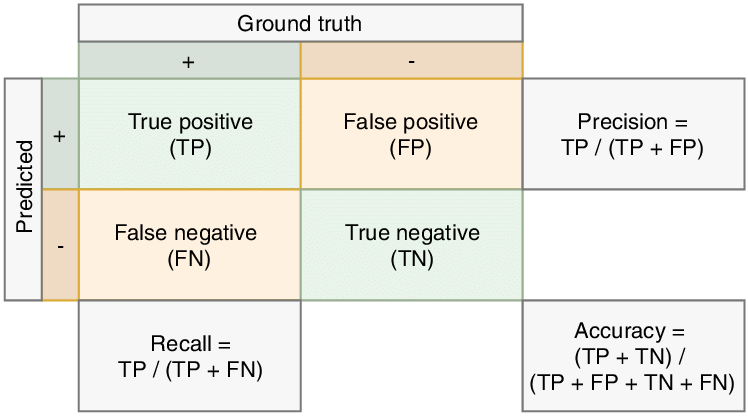 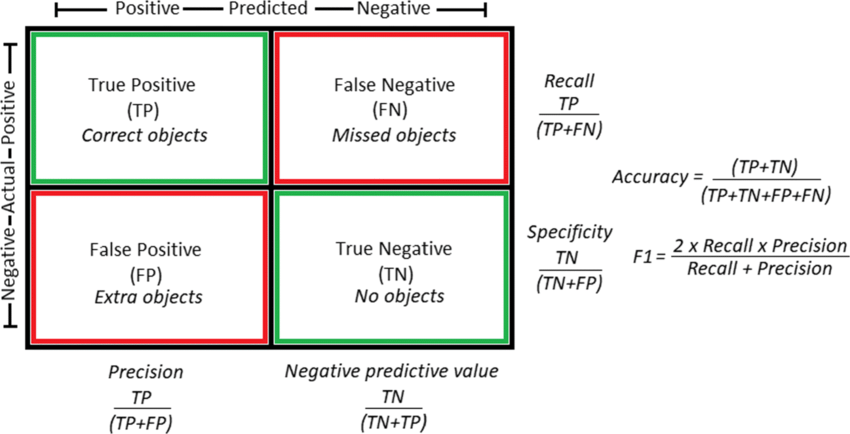

In [52]:
# 유효성 검사에 사용할 메트릭을 정의합니다.
accuracy = evaluate.load("accuracy")

다음 코드는 모델의 평가 과정에서 사용되는 `compute_metrics` 함수를 정의하고 있습니다. 이 함수는 평가 예측(`eval_pred`)을 받아 평가 지표를 계산하고 반환합니다.

함수의 동작을 단계별로 설명하면 다음과 같습니다:

1. `predictions, _= eval_pred`: 평가 예측(`eval_pred`)에서 예측값(`predictions`)과 레이블을 언패킹합니다. 레이블은 `_`로 할당되어 무시됩니다.
   - 여기서 `predictions`는 각 텍스트 쌍에 대한 예측 rewards를 포함하는 2D 배열입니다. `rewards_j`는 첫 번째 텍스트의 예측 reward를, `rewards_k`는 두 번째 텍스트의 예측 reward를 나타냅니다.

2. 주석 처리된 부분은 함수의 목적을 설명하고 있습니다. 이 함수는 `rewards_j`가 `rewards_k`를 초과하는 경우의 비율을 계산하고자 합니다.

3. `predictions = np.argmax(predictions, axis=0)`: `predictions` 배열에서 `axis=0`을 기준으로 가장 큰 값의 인덱스를 찾아 `predictions`에 할당합니다.
   - 이는 각 텍스트 쌍에 대해 `rewards_j`와 `rewards_k` 중 더 큰 값을 선택하는 것과 같습니다.
   - `np.argmax()`는 NumPy 라이브러리의 함수로, 배열에서 최대값의 인덱스를 반환합니다.

4. `labels = np.zeros(predictions.shape)`: `predictions`와 동일한 모양의 0으로 채워진 `labels` 배열을 생성합니다.
   - 이는 모든 예측에 대해 레이블을 0으로 설정하는 것을 의미합니다.
   - 여기서는 `rewards_j`가 `rewards_k`를 초과하는 경우를 정답으로 간주하고, 그렇지 않은 경우를 오답으로 처리합니다.

5. `return accuracy.compute(predictions=predictions, references=labels)`: `accuracy` 평가 지표를 사용하여 예측값(`predictions`)과 레이블(`labels`)을 비교하고 정확도를 계산한 후 반환합니다.
   - `accuracy.compute()`는 예측값과 레이블을 받아 정확도를 계산하는 함수입니다.

이 함수는 모델의 예측 결과에서 `rewards_j`가 `rewards_k`를 초과하는 비율을 정확도로 계산합니다. 예를 들어, 정확도가 0.8이라면 전체 예측 중 80%의 경우에서 `rewards_j`가 `rewards_k`보다 큰 것으로 해석할 수 있습니다.

이 함수는 `Trainer`의 `compute_metrics` 인자로 전달되어 모델의 평가 과정에서 호출됩니다. 평가 지표를 계산하고 반환함으로써 모델의 성능을 평가하고 모니터링할 수 있습니다.

In [53]:
def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # 여기서 예측은 rewards_j와 rewards_k입니다. 보상_j가 보상_k를 초과하는 경우가 얼마나 되는지 확인하고자 합니다.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape)
    return accuracy.compute(predictions=predictions, references=labels)

위의 코드는 Hugging Face의 `Trainer` 클래스를 상속받아 사용자 정의 손실 함수를 구현한 `RewardTrainer` 클래스를 정의하고 있습니다. 이 클래스는 모델의 학습 과정에서 사용되며, 특정 작업에 대한 손실을 계산하는 방법을 재정의합니다.

`compute_loss` 메서드는 모델, 입력 데이터, 그리고 출력 반환 여부를 인자로 받아 손실을 계산하고 반환합니다. 이 메서드의 동작을 단계별로 설명하면 다음과 같습니다:

1. `rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]`: 모델을 사용하여 선호하는 응답 y_j에 대한 보상(reward)을 계산합니다. y_j에 대한 입력 토큰 ID(`input_ids_j`)와 어텐션 마스크(`attention_mask_j`)를 모델에 전달하여 출력의 첫 번째 요소를 `rewards_j`에 할당합니다.

2. `rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]`: 선호도가 낮은 응답 y_k에 대한 보상도 동일한 방식으로 계산하여 `rewards_k`에 할당합니다.

3. 음의 로그 우도(Negative Log-Likelihood) 손실 함수를 사용하여 손실을 계산합니다:
   - `rewards_j - rewards_k`: y_j와 y_k에 대한 보상 차이를 계산합니다.
   - `torch.pow(torch.tensor(inputs['score_diff'], device=rewards_j.device), 2)`: 입력으로 제공된 점수 차이(`score_diff`)를 PyTorch 텐서로 변환하고, 제곱합니다. 이는 점수 차이의 영향을 강조하기 위한 것입니다.
   - `(rewards_j - rewards_k) * torch.pow(torch.tensor(inputs['score_diff'], device=rewards_j.device), 2)`: 보상 차이와 점수 차이의 제곱을 곱합니다.
   - `nn.functional.logsigmoid(...)`: 시그모이드 함수의 로그 값을 계산합니다. 이는 이진 분류 문제에서 사용되는 손실 함수 중 하나입니다.
   - `-nn.functional.logsigmoid(...)`: 로그 시그모이드 값에 음수를 취합니다.
   - `.mean()`: 배치 내의 모든 예제에 대해 평균 손실을 계산합니다.

4. `if return_outputs`: 출력 반환 여부에 따라 다음과 같이 동작합니다:
   - `return_outputs`가 True이면, 계산된 손실과 함께 `rewards_j`와 `rewards_k`를 딕셔너리 형태로 반환합니다.
   - `return_outputs`가 False이면, 계산된 손실만 반환합니다.

이렇게 정의된 `RewardTrainer` 클래스는 `Trainer` 클래스를 상속받아 사용자 정의 손실 함수를 구현합니다. 이 손실 함수는 선호하는 응답과 선호도가 낮은 응답 간의 보상 차이와 점수 차이를 고려하여 손실을 계산합니다. 이를 통해 모델이 선호도에 따라 응답을 학습할 수 있도록 유도합니다.

In [54]:
# Hugging Face Trainer 클래스를 서브클래싱하여 손실 계산을 사용자 정의하고 있습니다.
class RewardTrainer(Trainer):
    # 특정 작업의 손실을 계산하는 방법을 정의하기 위해 compute_loss 함수를 재정의합니다.
    def compute_loss(self, model, inputs, return_outputs=False):
        # 모델을 사용하여 선호 응답 y_j에 대한 리워드를 계산합니다. y_j에 대한 input_ids와 attention_mask는 입력으로 제공됩니다.
        rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]

        # 마찬가지로 선호도가 낮은 응답 y_k에 대한 리워드도 계산합니다.
        rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]
        
        # 음의 로그 우도 함수를 사용하여 손실을 계산합니다. 
        # 보상 차이(보상_j - 보상_k)를 구하고 입력에 제공된 점수 차이의 제곱을 곱합니다. 
        # 그런 다음, 시그모이드 함수를 적용하고(torch.nn.functional.logsigmoid를 통해) 결과를 음수화합니다. 
        # 평균 손실은 배치의 모든 예제에서 계산됩니다.
        loss = -nn.functional.logsigmoid((rewards_j - rewards_k) * torch.pow(torch.tensor(inputs['score_diff'], device=rewards_j.device), 2)).mean()
        
        # 손실과 함께 출력(y_j 및 y_k에 대한 보상)도 반환하고 싶다면 그렇게 합니다.
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}
        
        # 그렇지 않으면 단순히 계산된 손실을 반환합니다.
        return loss

## 참고. 음의 우도 함수
음의 로그 우도(Negative Log-Likelihood, NLL) 손실 함수는 확률 분포를 예측하는 모델의 손실을 계산하는 데 사용되는 함수입니다. 주로 분류 문제에서 사용되며, 모델이 예측한 확률 분포와 실제 레이블 간의 차이를 측정합니다.

NLL 손실 함수는 다음과 같이 정의됩니다:

```
NLL = -log(p[y])
```

여기서 `p[y]`는 모델이 예측한 확률 분포에서 실제 레이블 `y`에 해당하는 확률값입니다.

예를 들어, 이진 분류 문제에서 모델이 어떤 샘플이 양성(positive)일 확률을 0.7로 예측했고, 실제 레이블이 양성(1)이라면 NLL 손실 함수의 값은 다음과 같이 계산됩니다:

```
NLL = -log(0.7) ≈ 0.357
```

NLL 손실 함수는 모델이 실제 레이블에 대해 높은 확률을 할당할수록 작은 값을 가지며, 실제 레이블에 대해 낮은 확률을 할당할수록 큰 값을 가집니다. 따라서 모델은 NLL 손실을 최소화하는 방향으로 학습됩니다.

NLL 손실 함수는 다음과 같은 특징을 가집니다:

1. 실제 레이블에 대한 예측 확률이 높을수록 손실이 작아집니다.
2. 실제 레이블에 대한 예측 확률이 낮을수록 손실이 커집니다.
3. 로그 함수를 사용하여 확률 값을 음수화하고 스케일을 조정합니다.

NLL 손실 함수는 PyTorch와 같은 딥러닝 프레임워크에서 `nn.NLLLoss()`와 같은 형태로 구현되어 있습니다.

위의 코드에서는 NLL 손실 함수를 직접 구현하는 대신 시그모이드 함수의 로그 값을 사용하여 이진 분류 문제에서의 손실을 계산하고 있습니다. 이는 NLL 손실 함수와 유사한 역할을 하며, 모델이 선호하는 응답과 선호도가 낮은 응답을 구분하도록 학습하는 데 사용됩니다.

In [55]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

위 코드는 사용자 정의 `RewardTrainer` 클래스를 사용하여 `trainer` 객체를 생성하는 부분입니다. `RewardTrainer`는 이전에 설명한 대로 `Trainer` 클래스를 상속받아 사용자 정의 손실 함수를 구현한 클래스입니다.

`trainer` 객체는 다음과 같은 인자들을 받아 초기화됩니다:

1. `model`: 학습할 모델 객체입니다. 이전에 정의된 모델을 전달합니다.

2. `args`: 학습에 필요한 하이퍼파라미터와 설정 값들을 포함한 `TrainingArguments` 객체입니다. 이전에 정의된 `training_args`를 전달합니다.

3. `train_dataset`: 학습에 사용될 훈련 데이터셋입니다. `pairs_dataset['train']`을 전달하여 훈련 데이터셋을 지정합니다.

4. `eval_dataset`: 평가에 사용될 검증 데이터셋입니다. `pairs_dataset['test']`를 전달하여 검증 데이터셋을 지정합니다.

5. `compute_metrics`: 평가 지표를 계산하는 함수입니다. 이전에 정의된 `compute_metrics` 함수를 전달합니다. 이 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산하고 반환합니다.

6. `data_collator`: 데이터 배치를 생성하고 전처리하는 데이터 콜레이터입니다. `RewardDataCollatorWithPadding` 클래스의 인스턴스를 생성하여 전달합니다. 이 클래스는 `DataCollatorWithPadding`을 상속받아 사용자 정의 전처리 로직을 구현한 클래스입니다.
   - `tokenizer`: 데이터 전처리에 사용될 토크나이저를 지정합니다.
   - `max_length`: 시퀀스의 최대 길이를 지정합니다. 여기서는 512로 설정되어 있습니다.
   - `padding`: 패딩 전략을 지정합니다. 여기서는 'max_length'로 설정되어 있어 모든 시퀀스가 최대 길이로 패딩됩니다.

`trainer` 객체는 위에서 전달된 인자들을 사용하여 모델 학습, 평가, 예측 등의 작업을 수행할 수 있습니다. `trainer.train()`을 호출하면 모델 학습이 시작되고, `trainer.evaluate()`를 호출하면 평가가 수행됩니다.

이렇게 생성된 `trainer` 객체를 사용하여 사용자 정의 손실 함수와 데이터 콜레이터를 적용한 모델 학습을 진행할 수 있습니다. 이를 통해 선호하는 응답과 선호도가 낮은 응답 간의 차이를 고려하여 모델을 학습시킬 수 있습니다.

In [56]:
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=pairs_dataset['train'],
    eval_dataset=pairs_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(tokenizer=tokenizer, max_length=512, padding='max_length'),
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
trainer.evaluate()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: kimwooglae. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

{'eval_loss': 0.8108904957771301,
 'eval_accuracy': 0.2488176563321072,
 'eval_runtime': 1131.9411,
 'eval_samples_per_second': 16.812,
 'eval_steps_per_second': 0.526}

In [ ]:
trainer.train()

In [ ]:
# 유효성 검사 손실이 가장 적은 1 에포크 이후의 모델을 사용해 보겠습니다. 우리는 원시 정확도보다는 우리가 구축한 손실에 더 신경을 씁니다.

In [ ]:
trainer.save_model()

In [59]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [60]:
tokenizer.save_pretrained(training_args.output_dir+'/tokenizer')

('sawyer_rm/tokenizer/tokenizer_config.json',
 'sawyer_rm/tokenizer/special_tokens_map.json',
 'sawyer_rm/tokenizer/vocab.json',
 'sawyer_rm/tokenizer/merges.txt',
 'sawyer_rm/tokenizer/added_tokens.json',
 'sawyer_rm/tokenizer/tokenizer.json')

In [61]:
tokenizer.batch_decode(pairs_dataset['test'][0]['input_ids_k'])

['<s>How did the Battle of Gettysburg change the course of the American Civil War?</s></s>The battle of Gettysburg changed the course of the war.</s>']

다음 코드는 학습된 모델과 토크나이저를 불러오는 부분입니다.

1. `trained_model = AutoModelForSequenceClassification.from_pretrained('sawyer_rm', num_labels=1)`:
   - `AutoModelForSequenceClassification.from_pretrained()` 메서드를 사용하여 학습된 모델을 불러옵니다.
   - 첫 번째 인자로 모델이 저장된 디렉토리 경로인 'sawyer_rm'을 전달합니다. 이는 이전에 `trainer.save_model()`을 사용하여 모델을 저장한 경로입니다.
   - `num_labels=1`로 설정하여 이진 분류 문제임을 지정합니다. 이는 모델의 출력 레이블 수를 나타냅니다.
   - 불러온 모델은 `trained_model` 변수에 할당됩니다.

2. `tokenizer = AutoTokenizer.from_pretrained(model_name)`:
   - `AutoTokenizer.from_pretrained()` 메서드를 사용하여 사전 학습된 토크나이저를 불러옵니다.
   - 인자로 사전 학습된 모델의 이름인 `model_name`을 전달합니다. 이는 이전에 모델을 초기화할 때 사용한 모델 이름과 동일해야 합니다.
   - 불러온 토크나이저는 `tokenizer` 변수에 할당됩니다.

이렇게 불러온 `trained_model`과 `tokenizer`는 학습된 모델을 사용하여 추론(inference)을 수행하는 데 사용됩니다.

예를 들어, 새로운 입력 텍스트에 대한 추론을 수행하려면 다음과 같은 과정을 거칠 수 있습니다:

```python
input_text = "새로운 입력 텍스트"
encoded_input = tokenizer(input_text, return_tensors='pt')
output = trained_model(**encoded_input)
predicted_label = torch.sigmoid(output.logits).item()
```

위의 코드에서는 `input_text`를 토크나이저를 사용하여 인코딩하고, 인코딩된 입력을 `trained_model`에 전달하여 추론을 수행합니다. 출력의 로짓(logits)에 시그모이드 함수를 적용하여 예측된 레이블을 얻습니다.

이와 같이 학습된 모델과 토크나이저를 불러와 추론에 활용할 수 있습니다. 모델의 성능은 학습 과정에서의 하이퍼파라미터 설정, 데이터셋의 품질, 모델 아키텍처 등에 따라 달라질 수 있습니다.

In [62]:
trained_model = AutoModelForSequenceClassification.from_pretrained(
    'sawyer_rm', num_labels=1,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [63]:
# 여기서 마이너스 리워드를 기대합니다.
outputs = trained_model(**tokenizer('how do I greet someone?', 'Tell them to frick off', return_tensors='pt')).logits
outputs

tensor([[-0.5123]], grad_fn=<AddmmBackward0>)